# NextstepRNN

Predict the next position (x,y) given the last position and the latent state of a RNN cell.

## ToDos:

* data augmentation
* does the Masking work?
* publish metrics while training (callback)
* initial_state lernen
* MLP reintrainieren
* box plots for all data, to compare with Tobias
* curriculum learning: wichtig, um später im Livebetrieb zu verwenden
  * Evaluation: prüfe Abweichung mit groundtruth nachdem man n Schritte keine
  Messung mehr bekommen hat


In [1]:
# pin the tensorflow version
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 
logdir = './logs/'

# matplotlib rendering
%matplotlib inline

In [2]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install sklearn
!apt-get install wget

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
wget is already the newest version (1.19.4-1ubuntu2.2).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [3]:
import os
import io
import glob
import random
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorboard.plugins.hparams import api as hp

print('Tensorflow version:', tf.__version__)

tf.test.is_gpu_available()
plt.rcParams['figure.figsize'] = [20, 10]

Tensorflow version: 2.0.0


In [4]:
# Load the data and unzip quietly
!wget -N https://pollithy.com/Pfeffer.zip
!unzip -q -u Pfeffer.zip

--2019-11-15 14:19:15--  https://pollithy.com/Pfeffer.zip
Resolving pollithy.com (pollithy.com)... 87.118.94.85
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘Pfeffer.zip’ not modified on server. Omitting download.



In [5]:
# DATA LOADING
#
# The downloaded folder contains .csv-files which contain two columns per track.
# for example "TrackID_4_X" and "TrackID_4_Y".
# The code in this cell loads the tracks from the files and puts them into a 
# zero padded tensor with the shape: [num_tracks, num_time_steps, input_dim*2]
# Note: The "shifted" versions of the file seem to use one timestamps at a row.
#       This is not interesting for us.
#
# For every timestep the tensor contains: [x_t, y_t, x_{t+1}, y_{t+1}] where
#  t is the time step. 

# data loading parameter
num_time_steps = 35 # ToDo: Evaluate max length. 50
nan_value = 0
input_dim = 2

# collect all tracks from the files
tracks = []

file_list = sorted(glob.glob('Pfeffer/trackSortResultPfeffer/*_trackHistory_NothingDeleted.csv'))

for file_ in file_list:
  # read the tracks from one measurement
  df = pd.read_csv(file_)
  # remove columns with less then 6 detections (same as Tobias did)
  df.dropna(axis=1, thresh=6, inplace=True)
  # there are two columns per track, for example "TrackID_4_X" and "TrackID_4_Y"
  number_of_tracks = int((df.shape[1]) / 2)

  # We wan't to use 0.0 as NaN value. Therefore we have to check that it does not
  #   exist in the data.   Note: the double .min().min() is necessary because we
  #   first get the column minima and then we get the table minimum from that
  assert df.min().min() > 0.0, f"Error: The dataframe {file_} contains a minimum <= 0.0"

  # for every track we create:
  #  x, y, x_target, y_target zero padded
  for track_number in range(number_of_tracks):
    x = df.iloc[:, (2 * track_number)].to_numpy(copy=True)
    x = np.concatenate((x[:-1], np.array([nan_value])))
    y = df.iloc[:, (2 * track_number + 1)].to_numpy(copy=True)
    y = np.concatenate((y[:-1], np.array([nan_value])))
    
    # remove the last input because we have no target for it
    last_index = np.where(np.isnan(x))[0][0] - 1
    x[last_index] = np.nan
    y[last_index] = np.nan

    # the ground truth where to particle will be afterwards
    x_target = np.concatenate( ( df.iloc[:, (2 * track_number)].to_numpy(copy=True)[1:], np.array([nan_value]) ) )
    y_target = np.concatenate( ( df.iloc[:, (2 * track_number + 1)].to_numpy(copy=True)[1:], np.array([nan_value]) ) )

    input_matrix = np.vstack((x, y, x_target, y_target))
    input_matrix = np.nan_to_num(input_matrix, nan=nan_value)
    input_matrix = input_matrix

    # initialize the array with zeros
    matrix = np.zeros([num_time_steps, input_dim*2])

    # insert the data of the track into the zero "black" background
    matrix[0:x.size, 0:input_dim*2] = input_matrix.T

    tracks.append(matrix)

tracks = np.array(tracks)
print(tracks.shape)

(6963, 35, 4)


In [6]:
# Normalization
#
# For later use we have to store x_max and y_max in order to 
# apply and revert normalization. It might also be enough to
# set constant values like 2500 and 2000.

# normalize (x distinct of y)
x_max = np.nanmax(tracks[:, :, [0, 2]])
y_max = np.nanmax(tracks[:, :, [1, 3]])
print(f'x_max: {x_max} and y_max: {y_max}')

# now all values are in [0, 1.0]
tracks[:, :, [0, 2]] /= x_max
tracks[:, :, [1, 3]] /= y_max

x_max: 2181.72 and y_max: 1678.9327


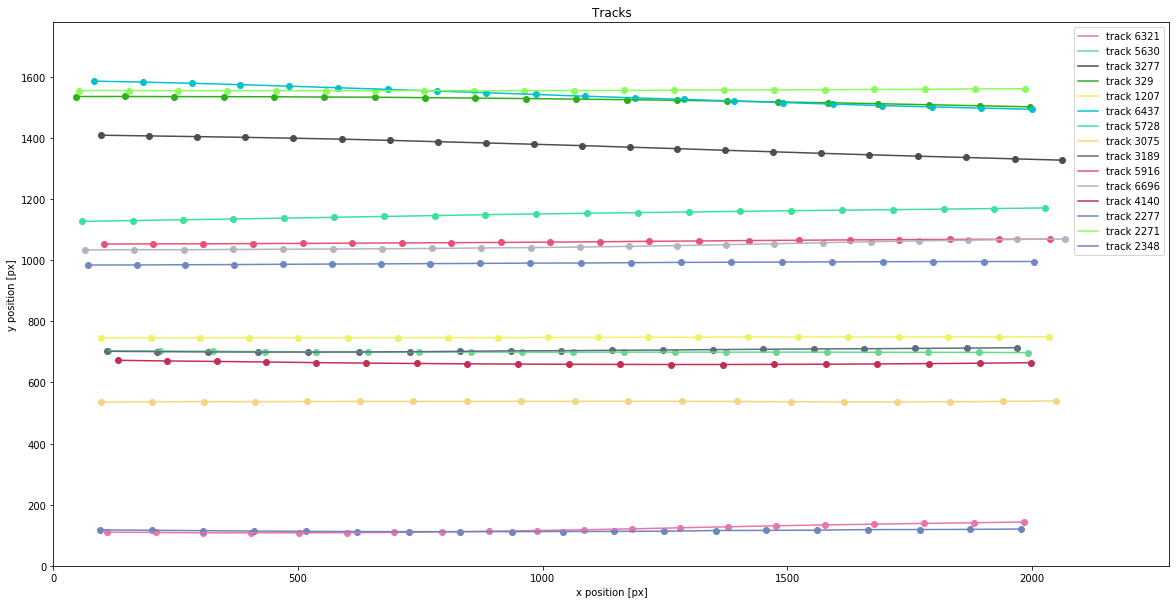

In [7]:
# track visualization
def plot_track(track, color='black', start=0, end=-1, label='track'):
  track = track[start:end]

  axes = plt.gca()
  axes.set_xlim([0, x_max + 100])
  axes.set_ylim([0, y_max + 100])

  plt.xlabel('x position [px]')
  plt.ylabel('y position [px]')
  axes.scatter(track[:, 1] * x_max, track[:, 0] * y_max, color=color)
  axes.plot(track[:, 1] * x_max, track[:, 0] * y_max, color=color, label=label)
  axes.legend()

  return axes

def get_last_timestep_of_track(track):
  for i in range(track.shape[0]):
    if not np.any(track[i]):
      return i
  return i
  
for _ in range(15):
  random_index = random.randint(0, tracks.shape[0] - 1)
  random_track = tracks[random_index]
  axes = plot_track(random_track, color=np.random.rand(3), 
                    end=get_last_timestep_of_track(random_track),
                    label=f'track {random_index}')
  plt.title(f'Tracks')
plt.show()

In [8]:
# split into train and test splits
test_split_size = 0.1

train_tracks, test_tracks = train_test_split(tracks, test_size=test_split_size)

In [9]:
# Tensorflow Dataset API

# Training examples
batch_size = 128

raw_train_dataset = tf.data.Dataset.from_tensor_slices(train_tracks)
raw_test_dataset = tf.data.Dataset.from_tensor_slices(test_tracks)

# for optimal shuffling the shuffle buffer has to be of the size of the number
# of tracks
minibatches_train = raw_train_dataset.shuffle(train_tracks.shape[0]).batch(batch_size, drop_remainder=True)
minibatches_test = raw_test_dataset.shuffle(test_tracks.shape[0]).batch(batch_size, drop_remainder=True)

# We want to train the RNN to solve a Seq2Seq problem:
# For each sequence:
#  - duplicate it
#  - and shift it to form the input and target sequence
#    by using the map method

def split_input_target(chunk):
  # split the tensor (x, y, x_target, y_target) 
  #  -> into two tensors (x, y) and (x_target, y_target)
  input_seq =  chunk[:, :, :2]
  target_seq = chunk[:, :, 2:]
  return input_seq, target_seq

dataset_train = minibatches_train.map(split_input_target)
dataset_test = minibatches_test.map(split_input_target)

In [56]:
# HParams Dashboard for Tensorboard
# -> used for hyperparameter optimization

HP_NUM_UNITS = hp.HParam('num_units_per_layer', hp.Discrete([256]))
HP_NUM_LAYERS = hp.HParam('num_lstm_layers', hp.Discrete([3]))
HP_INITIAL_LR = hp.HParam('initial_lr',  hp.Discrete([0.01])) # hp.RealInterval(0.1))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))

METRIC_MSE = 'mse'
METRIC_MAE = 'mae'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_OPTIMIZER, HP_NUM_LAYERS, HP_INITIAL_LR],
    metrics=[
             hp.Metric(METRIC_MSE, display_name='MSE'),
             hp.Metric(METRIC_MAE, display_name='MAE')
             ],
)

In [57]:
# model factory
def model_factory(hparams):
  model = tf.keras.Sequential()

  # The Masking makes the model ignore timesteps where the whole vector
  # consists of the *mask_value* 
  model.add(tf.keras.layers.Masking(mask_value=nan_value, 
                                    name="in_layer", 
                                    batch_input_shape=(batch_size, num_time_steps, input_dim)))
  for i in range(hparams[HP_NUM_LAYERS]):
    model.add(tf.keras.layers.LSTM(hparams[HP_NUM_UNITS], 
                                    return_sequences=True, 
                                    stateful=False, 
                                    unroll=True,
                                    recurrent_initializer='glorot_uniform'))
    
  model.add(tf.keras.layers.Dense(64))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
  model.add(tf.keras.layers.BatchNormalization())    
    
  model.add(tf.keras.layers.Dense(16))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Dense(2))
    
  return model


In [58]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

reduce_learning_rate_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',  # usually val_loss is used but as they do not really differ we can also use the loss directly
    verbose=1,  # show update messages
    factor=0.1,
    patience=10, 
    min_lr=0.000001)

In [21]:
%tensorboard --logdir logs --host 0.0.0.0 --port 6006

In [59]:
# make some graphics to evaluate qualitatively
def plot_tracks(n=5):
    for input_example_batch, target_example_batch in dataset_test.take(1):
        # hidden = model.reset_states()
        example_batch_predictions = model(input_example_batch)
        for i in range(n):
            seq_length = get_last_timestep_of_track(input_example_batch[i])
            axes = plot_track(input_example_batch[i], color='black', end=seq_length, label="Input truth")
            axes = plot_track(target_example_batch[i], color='green', end=seq_length, label="Output truth")
            axes = plot_track(example_batch_predictions[i], color='blue', end=seq_length, label="NextStep-RNN")
            plt.title(f'Track with predictions')

            # store plot in memory buffer
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            # Convert PNG buffer to TF image
            image = tf.image.decode_png(buf.getvalue(), channels=4)
            # add batch dim
            image = tf.expand_dims(image, 0)
            tf.summary.image("plot", image, step=1)

        plt.show()

In [60]:
# Grid Search

EPOCHS=200
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for num_layers in HP_NUM_LAYERS.domain.values:
    hparams = {
        HP_NUM_UNITS: num_units,
        HP_OPTIMIZER: 'adam',
        HP_NUM_LAYERS: num_layers,
        HP_INITIAL_LR: 0.1 # hparams[HP_INITIAL_LR]
    }
    run_name = f"run-{session_num}-{time.time()}"
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run_dir = 'logs/hparam_tuning/' + run_name

    # run the training and evaluation for one model
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial

        model = model_factory(hparams)
        print(model.summary())

        optimizer = 'adam'  # tf.keras.optimizers.Adam(learning_rate=hparams[HP_INITIAL_LR])

        # hparams[HP_OPTIMIZER]
        model.compile(optimizer=optimizer, 
                      loss='mean_squared_error',
                      metrics=['mse', 'mae'])

        history = model.fit(dataset_train, 
                    epochs=EPOCHS,
                    validation_data=dataset_test,
                    validation_freq=10,
                    callbacks=[
                               tf.keras.callbacks.TensorBoard(logdir),  # log metrics
                               hp.KerasCallback(logdir, hparams),  # log hparams
                               checkpoint_callback,
                               reduce_learning_rate_on_plateau
                               ]
        )

        _, mse, mae = model.evaluate(dataset_test)
        tf.summary.scalar(METRIC_MSE, mse, step=1)
        tf.summary.scalar(METRIC_MAE, mae, step=1)

        plot_tracks()
       
    session_num += 1


--- Starting trial: run-0-1573830606.9772384
{'num_units_per_layer': 256, 'optimizer': 'adam', 'num_lstm_layers': 3, 'initial_lr': 0.1}
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in_layer (Masking)           (128, 35, 2)              0         
_________________________________________________________________
lstm_19 (LSTM)               (128, 35, 256)            265216    
_________________________________________________________________
lstm_20 (LSTM)               (128, 35, 256)            525312    
_________________________________________________________________
lstm_21 (LSTM)               (128, 35, 256)            525312    
_________________________________________________________________
dense_26 (Dense)             (128, 35, 64)             16448     
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (128, 35, 64)        

48/48 [==============================] - 2s 36ms/step - loss: 4.6081e-04 - mse: 8.1202e-04 - mae: 0.0156 - val_loss: 4.2807e-04 - val_mse: 7.6277e-04 - val_mae: 0.0148
Epoch 51/200
48/48 [==============================] - 2s 35ms/step - loss: 5.0152e-04 - mse: 9.0299e-04 - mae: 0.0163
Epoch 52/200
48/48 [==============================] - 2s 36ms/step - loss: 4.5966e-04 - mse: 8.0977e-04 - mae: 0.0155
Epoch 53/200
48/48 [==============================] - 2s 36ms/step - loss: 4.9146e-04 - mse: 8.9088e-04 - mae: 0.0166
Epoch 54/200
47/48 [============================>.] - ETA: 0s - loss: 5.2916e-04 - mse: 9.4318e-04 - mae: 0.0175
Epoch 00054: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
48/48 [==============================] - 2s 35ms/step - loss: 5.2917e-04 - mse: 9.4494e-04 - mae: 0.0176
Epoch 55/200
48/48 [==============================] - 2s 35ms/step - loss: 4.7292e-04 - mse: 8.4467e-04 - mae: 0.0164
Epoch 56/200
48/48 [==============================] - 2s 35ms

KeyboardInterrupt: 

In [61]:
# IMPORTANT:
# The NextStep-RNN only worked if it was supplied with 4 initial data points.
# -> but the first predictions were the hardest. Therefore the error is much
#    higher at the beginning.
# Therefore I created the following evaluation which ignores the first four
#  predictions in order to compare our results with results of Tobias.
#
# In this "benchmark" we would calculate the loss as we did because the network
#  focuses on minimizing the large loss of the first time steps.
#  -> we don't change this, because predicting the first timesteps is our main goal.

mses = []

it = -1

# at which step to start evaluation
seq_start = 4  # 4

print("Generating l2 by hand for validation: ")

for input_example_batch, target_example_batch in dataset_test:
  it += 1
  print('.', end='')
  hidden = model.reset_states()
  example_batch_predictions = model(input_example_batch)

  for i in range(example_batch_predictions.shape[0]):
    seq_end = get_last_timestep_of_track(input_example_batch[i])

    if seq_end <= seq_start:
      continue

    y_correct = target_example_batch[i][seq_start:seq_end].numpy()
    y_correct[:, 0] *= x_max
    y_correct[:, 1] *= y_max

    y_predicted = example_batch_predictions[i][seq_start:seq_end].numpy()
    y_predicted[:, 0] *= x_max
    y_predicted[:, 1] *= y_max

    mse = np.linalg.norm(y_correct - y_predicted, axis=1, ord=2)
    mses.append(np.mean(mse))   


print(np.mean(mses))

Generating l2 by hand for validation: 

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

....23.52685326144224


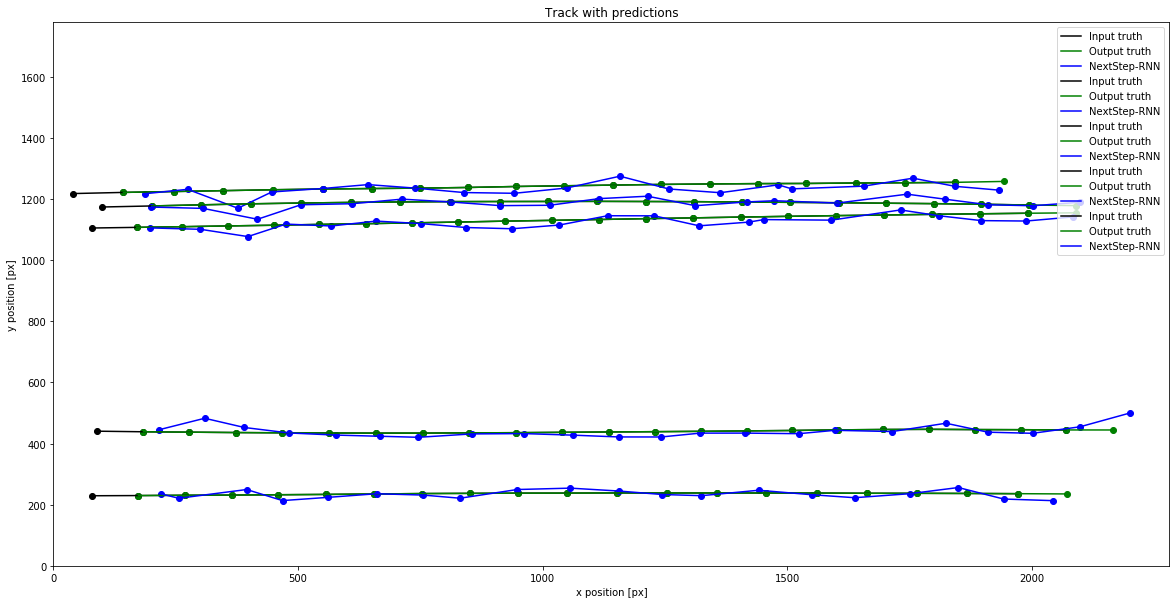

In [62]:
plot_tracks()

In [16]:
#!rm -rf ./logs ./training_checkpoints

In [17]:
# !kill 2298